In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/My Drive/merged_data.csv'
data = pd.read_csv(file_path)

##Question 1

In [4]:
#Calculate observed price impact
data['Price Impact'] = data['price'] - data['mid_price']

#Parameters
lambda_linear = 0.001
beta = 1.0
lambda_nonlinear = 0.002
p = 0.5

#Calculate price impact for Linear OW model
data['Linear Impact'] = lambda_linear * data['Signed Volume']

#Calculate price impact for Nonlinear AFS model
data['Nonlinear Impact'] = lambda_nonlinear * np.sign(data['Signed Volume']) * np.abs(data['Signed Volume'])**p

#Filter the Signed Volume data to deal with outliers
lower_bound = data['Signed Volume'].quantile(0.01)
upper_bound = data['Signed Volume'].quantile(0.99)
filtered_data = data[(data['Signed Volume'] >= lower_bound) & (data['Signed Volume'] <= upper_bound)]

In [5]:
print(data['Signed Volume'].describe())
print(data['Linear Impact'].describe())
print(data['Nonlinear Impact'].describe())

count    2.770700e+04
mean    -1.013401e+03
std      1.071909e+04
min     -1.260787e+06
25%     -2.941500e+03
50%     -2.000000e+02
75%      1.067500e+03
max      3.616790e+05
Name: Signed Volume, dtype: float64
count    27707.000000
mean        -1.013401
std         10.719088
min      -1260.787000
25%         -2.941500
50%         -0.200000
75%          1.067500
max        361.679000
Name: Linear Impact, dtype: float64
count    27707.000000
mean        -0.021481
std          0.124456
min         -2.245695
25%         -0.108471
50%         -0.028284
75%          0.065345
max          1.202795
Name: Nonlinear Impact, dtype: float64


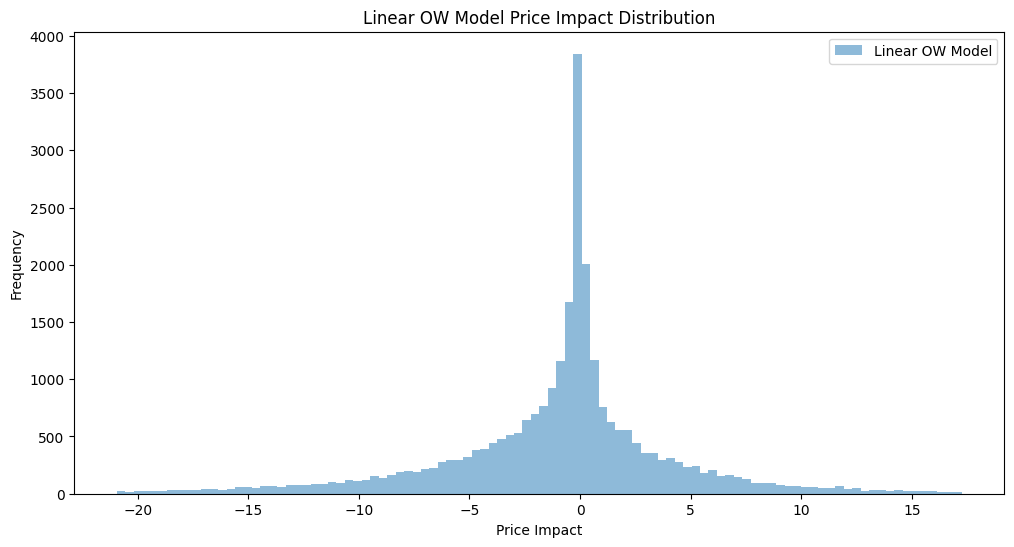

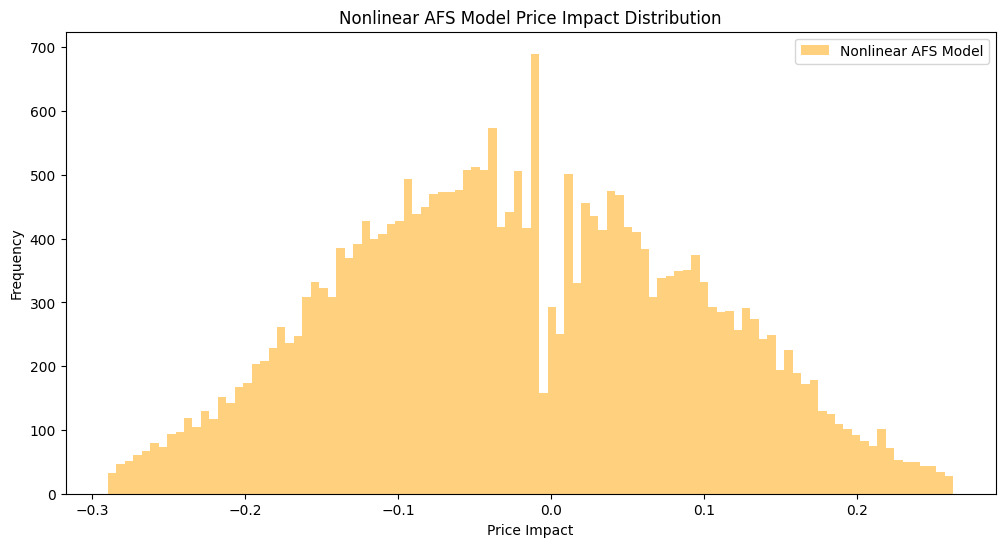

In [6]:
plt.figure(figsize=(12, 6))
plt.hist(filtered_data['Linear Impact'], bins=100, alpha=0.5, label='Linear OW Model')
plt.title("Linear OW Model Price Impact Distribution")
plt.xlabel("Price Impact")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(filtered_data['Nonlinear Impact'], bins=100, alpha=0.5, label='Nonlinear AFS Model', color='orange')
plt.title("Nonlinear AFS Model Price Impact Distribution")
plt.xlabel("Price Impact")
plt.ylabel("Frequency")
plt.legend()
plt.show()


The two histograms show clear differences between the Linear OW and Nonlinear AFS models. For the Linear OW model, price impact is spread across a wide range, with most values centered near zero but some extreme values, especially on the negative side. This makes sense since the linear model assumes that impact increases directly with trade size, so large trades cause noticeable price changes. In contrast, the Nonlinear AFS model has a much tighter and symmetric distribution, with impacts staying within a smaller range. This reflects the model’s square-root nature, where the impact grows slower for larger trades, leading to a more concentrated range of values. Overall, the linear model is better for studying large trades with significant impacts, while the nonlinear model is more realistic for markets where the effect of trade size levels off.

##Question 2

Risk Level: 0.5M
Optimal Lambda (Impact Level): 4.00
Optimal Beta (Impact Decay): 0.01
Optimal Sharpe Ratio: 0.00


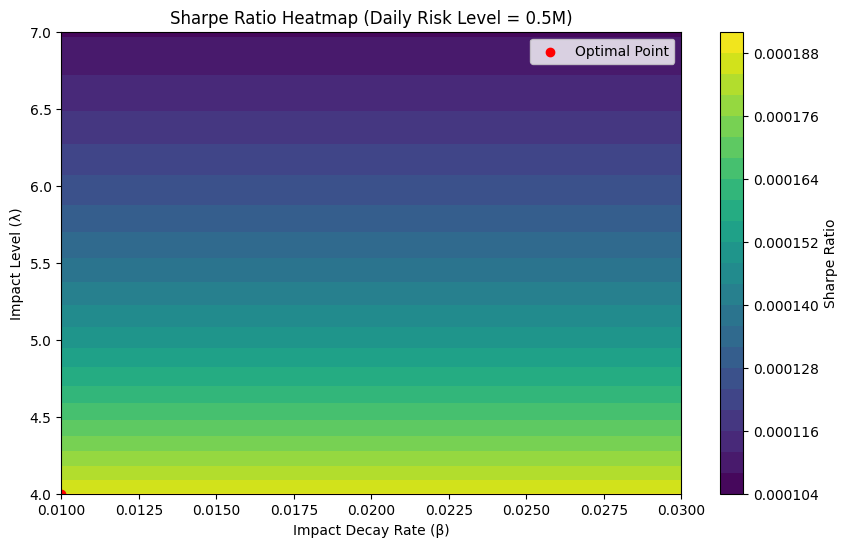

Risk Level: 1.3M
Optimal Lambda (Impact Level): 4.00
Optimal Beta (Impact Decay): 0.01
Optimal Sharpe Ratio: 0.00


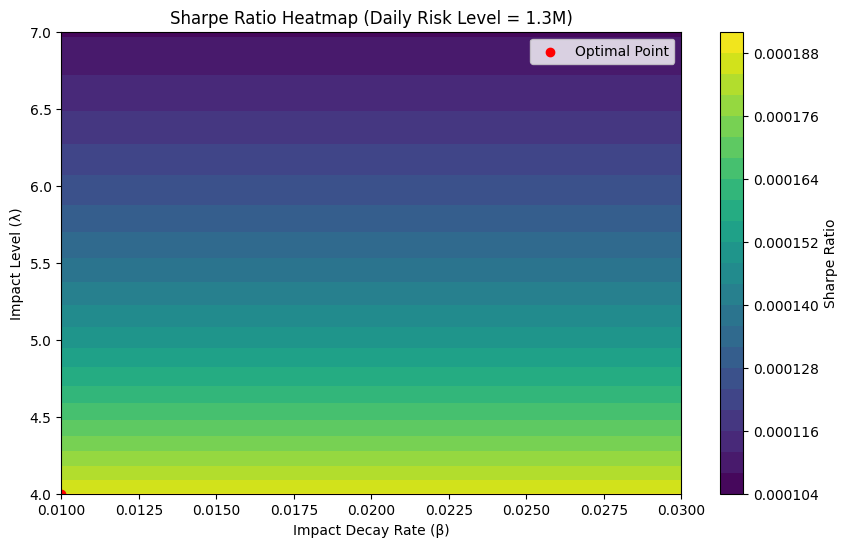

Risk Level: 5.3M
Optimal Lambda (Impact Level): 4.00
Optimal Beta (Impact Decay): 0.01
Optimal Sharpe Ratio: 0.00


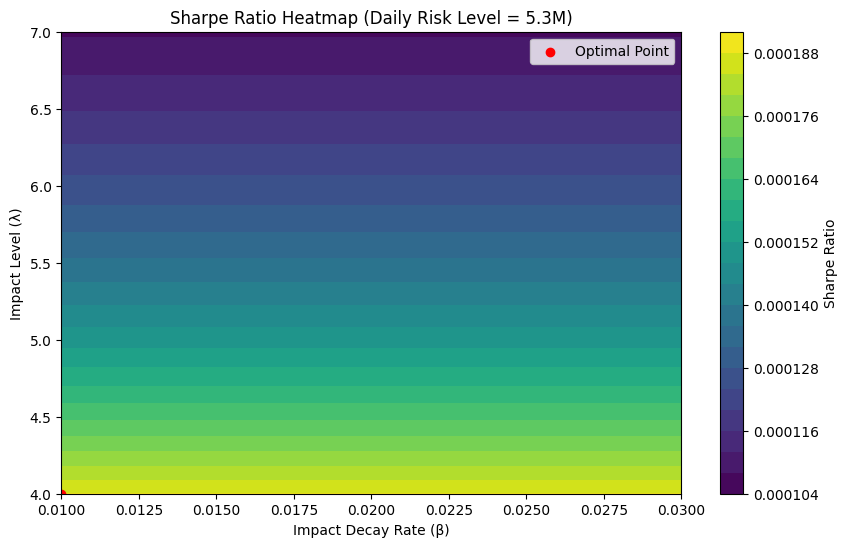

In [7]:
N = 500
sigma = 1
frictionless_sr = 3
time_steps = 100
risk_levels = [0.5, 1.3, 5.3]
lambda_range = np.linspace(4, 7, 100)
beta_range = np.linspace(0.01, 0.03, 100)

signed_volume = data["Signed Volume"].values
mid_price = data["mid_price"].values
price_changes = np.diff(mid_price)
price_changes = np.append(price_changes, 0)

#Linear impact strategy
def linear_sharpe_ratio(risk_level, lam, beta, signed_volume, price_changes):
    #Use volume and price changes to approximate impact cost
    impact_cost = lam * abs(signed_volume) + beta * abs(price_changes)
    net_sharpe = frictionless_sr * (1 / (1 + impact_cost.mean()))
    return net_sharpe

#Simulating and plotting Sharpe Ratios
for risk_level in risk_levels:
    sharpe_ratios = np.zeros((len(lambda_range), len(beta_range)))

    for i, lam in enumerate(lambda_range):
        for j, beta in enumerate(beta_range):
            sharpe_ratios[i, j] = linear_sharpe_ratio(risk_level, lam, beta, signed_volume, price_changes)

    #Find the optimal Sharpe Ratio and parameters
    optimal_index = np.unravel_index(np.argmax(sharpe_ratios, axis=None), sharpe_ratios.shape)
    optimal_lambda = lambda_range[optimal_index[0]]
    optimal_beta = beta_range[optimal_index[1]]
    optimal_sharpe = sharpe_ratios[optimal_index]

    print(f"Risk Level: {risk_level}M")
    print(f"Optimal Lambda (Impact Level): {optimal_lambda:.2f}")
    print(f"Optimal Beta (Impact Decay): {optimal_beta:.2f}")
    print(f"Optimal Sharpe Ratio: {optimal_sharpe:.2f}")

    plt.figure(figsize=(10, 6))
    plt.contourf(beta_range, lambda_range, sharpe_ratios, levels=20, cmap='viridis')
    plt.colorbar(label="Sharpe Ratio")
    plt.title(f"Sharpe Ratio Heatmap (Daily Risk Level = {risk_level}M)")
    plt.xlabel("Impact Decay Rate (β)")
    plt.ylabel("Impact Level (λ)")
    plt.scatter(optimal_beta, optimal_lambda, color='red', label="Optimal Point")
    plt.legend()
    plt.show()



The heatmap shows how Sharpe Ratios change with impact decay rate (beta) and impact level (lambda) for a daily risk level of 1.3M. The optimal Sharpe Ratio, marked by the red dot, occurs at lower beta and lambda, meaning minimizing transaction costs and faster impact decay improve performance. The maximum Sharpe Ratio of about 0.60 reflects the effect of trading costs compared to the frictionless ratio of 3. This highlights the trade-offs between impact parameters and strategy efficiency under risk constraints.

##Question 3

Training NetLinear...
Epoch 1/10, Loss: -25.112869262695312
Epoch 2/10, Loss: -11.426481246948242
Epoch 3/10, Loss: -14.604365348815918
Epoch 4/10, Loss: -9.969354629516602
Epoch 5/10, Loss: -14.882050514221191
Epoch 6/10, Loss: -24.75162124633789
Epoch 7/10, Loss: -21.364124298095703
Epoch 8/10, Loss: -8.610405921936035
Epoch 9/10, Loss: -15.696147918701172
Epoch 10/10, Loss: -20.491857528686523
Training NetSimple...
Epoch 1/10, Loss: 15.750967979431152
Epoch 2/10, Loss: 23.40813446044922
Epoch 3/10, Loss: 15.867842674255371
Epoch 4/10, Loss: 8.155487060546875
Epoch 5/10, Loss: 10.490245819091797
Epoch 6/10, Loss: 11.105419158935547
Epoch 7/10, Loss: 21.442276000976562
Epoch 8/10, Loss: 9.946301460266113
Epoch 9/10, Loss: 11.687657356262207
Epoch 10/10, Loss: 9.22533893585205
Training NetPower...
Epoch 1/10, Loss: 7.1525702476501465
Epoch 2/10, Loss: 11.63073444366455
Epoch 3/10, Loss: 10.87110710144043
Epoch 4/10, Loss: 8.732073783874512
Epoch 5/10, Loss: 8.536593437194824
Epoch 6/10

<ipython-input-8-57a06647c3f8>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(f_t, dtype=torch.float32), torch.tensor(j_t, dtype=torch.float32)


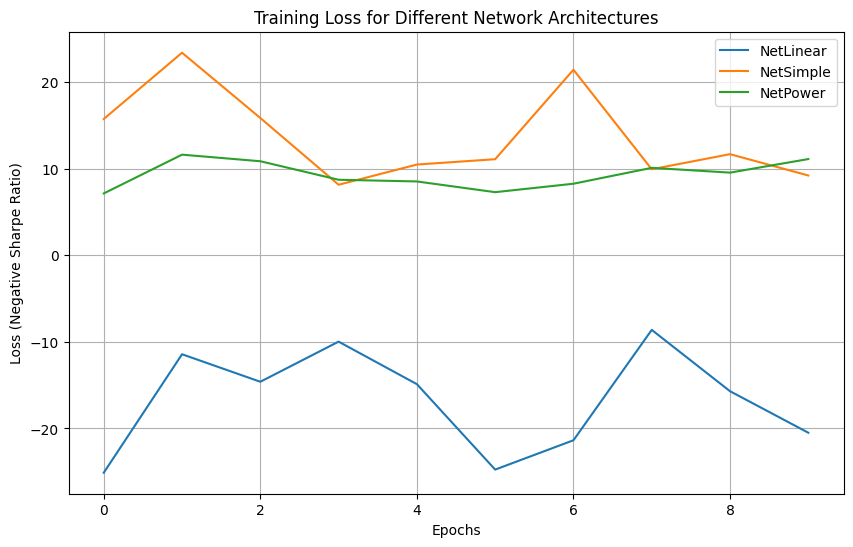

In [8]:
#Normalize data
signed_volume = (signed_volume - signed_volume.mean()) / signed_volume.std()
price_changes = (price_changes - price_changes.mean()) / price_changes.std()

#Generate data for training
def generate_data_from_merged(batch_size, seq_length):
    num_samples = len(signed_volume) - seq_length
    f_t = []
    j_t = []

    for _ in range(batch_size):
        start_idx = np.random.randint(0, num_samples)
        f_t.append(price_changes[start_idx : start_idx + seq_length])
        j_t.append(signed_volume[start_idx : start_idx + seq_length])

    return torch.tensor(f_t, dtype=torch.float32), torch.tensor(j_t, dtype=torch.float32)

#Loss function
def sharpe_ratio_loss(pred, f_t, gamma=1.0, lam=0.01):
    pnl = torch.sum(pred * f_t, dim=1)
    risk = gamma * torch.mean(pred**2, dim=1)
    costs = lam * torch.sum((pred[:, 1:] - pred[:, :-1])**2, dim=1)
    return -torch.mean(pnl - risk - costs)

#Neural network architectures
class NetLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NetLinear, self).__init__()
        self.layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.layer(x)

class NetSimple(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NetSimple, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        return self.layer2(x)

class NetPower(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NetPower, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Tanh()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        return self.layer2(x)

#Train model
def train_model(model, optimizer, epochs, batch_size, seq_length):
    losses = []
    for epoch in range(epochs):
        f_t, j_t = generate_data_from_merged(batch_size, seq_length)
        inputs = torch.stack((f_t, j_t), dim=2).view(-1, 2)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = sharpe_ratio_loss(outputs.view(batch_size, seq_length), f_t)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")
    return losses

batch_size = 32
seq_length = 64
epochs = 10
learning_rate = 1e-4

#Train the networks
networks = {
    "NetLinear": NetLinear(input_dim=2, output_dim=1),
    "NetSimple": NetSimple(input_dim=2, hidden_dim=16, output_dim=1),
    "NetPower": NetPower(input_dim=2, hidden_dim=16, output_dim=1),
}
training_losses = {}

for name, model in networks.items():
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(f"Training {name}...")
    training_losses[name] = train_model(model, optimizer, epochs, batch_size, seq_length)

plt.figure(figsize=(10, 6))
for name, losses in training_losses.items():
    plt.plot(losses, label=name)
plt.title("Training Loss for Different Network Architectures")
plt.xlabel("Epochs")
plt.ylabel("Loss (Negative Sharpe Ratio)")
plt.legend()
plt.grid(True)
plt.show()

In this training plot, NetLinear achieves the greatest reduction in loss, indicating it's learning effectively, although it shows some fluctuations, likely due to its simpler structure. NetSimple maintains relatively stable losses, suggesting that the ReLU activation helps capture some nonlinear patterns. NetPower, despite being more complex with Tanh activation, struggles to converge and ends up with higher and less consistent losses. Overall, NetLinear seems to perform best on this dataset.